# Homework 4

### Load Data

In [24]:
import pandas as pd

unsupervised_train_df = pd.read_csv('labelled_training_data.csv') # 70% of the data
unsupervised_test_df = pd.read_csv('labelled_testing_data.csv') # 15% of the data
unsupervised_validation_df = pd.read_csv('labelled_validation_data.csv') # 15% of the data

combined_df = pd.concat([unsupervised_train_df, unsupervised_test_df, unsupervised_validation_df], ignore_index=True)

### Feature Engineering

In [25]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

def feature_engineering(df, threshold=10.0):
    # --------------------
    # 1) Sort by Timestamp
    # --------------------
    df = df.sort_values('timestamp').reset_index(drop=True)
    
    # --------------------
    # 2) Create rolling count feature
    #    obs_count_in_window[i] = number of rows j where
    #    Timestamp_j >= Timestamp_i - threshold and j <= i
    # --------------------
    times = df['timestamp'].values
    # obs_count_in_window = []
    # start_idx = 0
    
    # for i in range(len(df)):
    #     current_t = times[i]
    #     while times[start_idx] < current_t - threshold:
    #         start_idx += 1
    #     obs_count_in_window.append(i - start_idx + 1)
    
    # df['obs_count_in_window'] = obs_count_in_window
    
    # --------------------
    # 3) Drop the original Timestamp
    # --------------------
    df.drop(columns=['timestamp'], inplace=True, errors='ignore')
    
    # --------------------
    # 4) processId -> binary (is it in {0,1,2}?)
    # --------------------
    df['processId_binary'] = df['processId'].apply(lambda x: 1 if x in [0,1,2] else 0)
    
    # --------------------
    # 5) threadId
    #    Often not used; we’ll drop it here.
    # --------------------
    df.drop(columns=['threadId'], inplace=True, errors='ignore')
    
    # --------------------
    # 6) parentProcessId -> binary (is it in {0,1,2}?)
    # --------------------
    df['parentProcessId_binary'] = df['parentProcessId'].apply(lambda x: 1 if x in [0,1,2] else 0)
    
    # --------------------
    # 7) userId -> binary (<1000 => 0, >=1000 => 1)
    # --------------------
    # df['userId_binary'] = df['userId'].apply(lambda x: 1 if x >= 1000 else 0)
    df.drop(columns=['userId'], inplace=True, errors='ignore')
    
    # --------------------
    # 8) mountNamespace -> binary
    #    e.g. 1 if == 4026532217, else 0
    # --------------------
    df['mountNamespace_binary'] = df['mountNamespace'].apply(lambda x: 1 if x == 4026532217 else 0)
    
    # --------------------
    # 9) processName -> one-hot encoding
    # --------------------
    processName_dummies = pd.get_dummies(df['processName'], prefix='proc')
    df = pd.concat([df, processName_dummies], axis=1)
    
    # --------------------
    # 10) Compute 'hostName_occurrences' (Count of same hostName in window)
    # --------------------
    df['hostName_occurrences'] = 0

    host_window_count = {} 
    start_idx = 0
    
    for i in range(len(df)):
        current_t = times[i]
        host = df.at[i, 'hostName']

        while times[start_idx] < current_t - threshold:
            old_host = df.at[start_idx, 'hostName']
            host_window_count[old_host] = host_window_count.get(old_host, 0) - 1
            if host_window_count[old_host] == 0:
                del host_window_count[old_host]
            start_idx += 1

        host_window_count[host] = host_window_count.get(host, 0) + 1
        df.at[i, 'hostName_occurrences'] = host_window_count[host]

    df.drop(columns=['hostName'], inplace=True, errors='ignore')

    # --------------------
    # 11) eventId (label-encode) and drop eventName
    # --------------------
    le_eventId = LabelEncoder()
    df['eventId_encoded'] = le_eventId.fit_transform(df['eventId'].astype(str))
    df.drop(columns=['eventName'], inplace=True, errors='ignore')
    
    # --------------------
    # 12) stackAddresses -> binary (empty or not)
    # --------------------
    def is_non_empty(addr):
        if pd.isna(addr):
            return 0
        return 1 if addr.strip() else 0
    
    df['stackAddresses_binary'] = df['stackAddresses'].apply(is_non_empty)
    
    # --------------------
    # 13) argsNum -> keep as numeric
    # --------------------
    # (No change needed)
    
    # --------------------
    # 14) returnValue -> map negative => -1, zero => 0, positive => 1
    # --------------------
    def map_return(val):
        if val < 0:
            return -1
        elif val == 0:
            return 0
        else:
            return 1
    df['returnValue_mapped'] = df['returnValue'].apply(map_return)
    
    # --------------------
    # 15) Sus -> drop
    # --------------------
    # dropped in the next step
    
    # --------------------
    # 16) Evil -> target
    # --------------------
    y = df['evil'].values
    
    # --------------------
    # 17) Drop columns we have replaced or do not need
    # --------------------
    df.drop(columns=[
        'processId',
        'parentProcessId',
        'userId',
        'mountNamespace',
        'processName',
        'hostName',
        'eventId',
        'stackAddresses',
        'returnValue',
        'sus',  
        'evil'
    ], inplace=True, errors='ignore')
    
    if 'args' in df.columns:
        df.drop(columns=['args'], inplace=True, errors='ignore')
    
    return df, y


Replace the original timestamp feature with a new feature that counts how many events occurred in the previous threshold seconds (or any chosen time window)

Binary Mappings for process IDs, parent process IDs, userId, mountNamespace, etc., simplify categorical IDs that have special “system” meaning (e.g., 0, 1, 2).

One-Hot Encoding for processName and hostName is straightforward for Logistic Regression interpretability. (You could use label encoding if the number of unique names is very large, or if you worry about high-dimensional sparse data.)

eventId vs eventName: We keep eventId but label-encode it. This is a compact representation, and eventName is dropped because it’s essentially the same information.

stackAddresses often are empty, so we simply create a binary “empty vs. not-empty.” 

replace hostName with a count of how many times the same hostName appears within a rolling \[threshold\] seconds time window.

returnValue is grouped into {-1, 0, +1}, capturing whether the call failed, succeeded with 0, or succeeded with a positive exit code.

### Prepare the Data for Supervised Learning

In [26]:
from sklearn.model_selection import train_test_split

df_evil_1 = combined_df[combined_df['evil'] == 1]
df_evil_0 = combined_df[combined_df['evil'] == 0]

min_size = min(len(df_evil_0), len(df_evil_1))

df_evil_0_balanced = df_evil_0.sample(n=min_size, random_state=42)
df_evil_1_balanced = df_evil_1.sample(n=min_size, random_state=42)

balanced_df = pd.concat([df_evil_0_balanced, df_evil_1_balanced]).sample(frac=1)

lr_train_df, lr_test_df = train_test_split(balanced_df, test_size=0.2)

print("Train set distribution:\n", lr_train_df['evil'].value_counts())
print("\nTest set distribution:\n", lr_test_df['evil'].value_counts())



Train set distribution:
 1    126940
0    126551
Name: evil, dtype: int64

Test set distribution:
 0    31881
1    31492
Name: evil, dtype: int64


In [27]:
from sklearn.model_selection import train_test_split

lr_imb_train_df, lr_imb_test_df = train_test_split(
    combined_df,
    test_size=0.2,           
    stratify=combined_df['evil']    
)

print("Train set distribution:")
print(lr_imb_train_df['evil'].value_counts())
print("\nTest set distribution:")
print(lr_imb_test_df['evil'].value_counts())

Train set distribution:
0    786116
1    126746
Name: evil, dtype: int64

Test set distribution:
0    196530
1     31686
Name: evil, dtype: int64


In [28]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score

X_train_bal, y_train_bal = feature_engineering(lr_train_df.copy(), threshold=10.0)
X_test_bal,  y_test_bal  = feature_engineering(lr_test_df.copy(),  threshold=10.0)

X_train_imb, y_train_imb = feature_engineering(lr_imb_train_df.copy(), threshold=10.0)
X_test_imb,  y_test_imb  = feature_engineering(lr_imb_test_df.copy(),  threshold=10.0)

X_test_bal = X_test_bal.reindex(columns=X_train_bal.columns, fill_value=0)
X_test_imb = X_test_imb.reindex(columns=X_train_imb.columns, fill_value=0)

NameError: name 'times' is not defined

The dataset is partitioned for Logistic Regression. Since we are not tunning the hyperparameter lambda, the dataset is been done in 80% train, 20% test. the balanced train-test set has a roughlt equal amount of evil and benigh observations. the imbalanced train-test set retained the orginal ratio. 

### Logistic Regression

In [12]:
lr_bal = LogisticRegression(solver='lbfgs', max_iter=10000)
lr_bal.fit(X_train_bal, y_train_bal)

lr_imb = LogisticRegression(solver='lbfgs', max_iter=10000)
lr_imb.fit(X_train_imb, y_train_imb)

LogisticRegression(max_iter=10000)

Balanced Dataset Test AUC: 1.000
Imbalanced Dataset Test AUC: 0.992


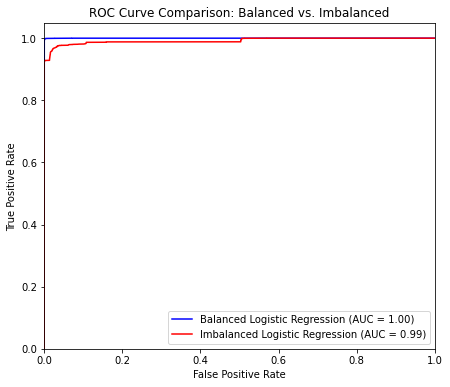

In [ ]:
y_scores_bal = lr_bal.predict_proba(X_test_bal)[:, 1]
fpr_bal, tpr_bal, _ = roc_curve(y_test_bal, y_scores_bal)
roc_auc_bal = auc(fpr_bal, tpr_bal)

y_scores_imb = lr_imb.predict_proba(X_test_imb)[:, 1] 
fpr_imb, tpr_imb, _ = roc_curve(y_test_imb, y_scores_imb)
roc_auc_imb = auc(fpr_imb, tpr_imb)

print(f"Balanced Dataset Test AUC: {roc_auc_bal:.3f}")
print(f"Imbalanced Dataset Test AUC: {roc_auc_imb:.3f}")

plt.figure(figsize=(7, 6))
plt.plot(fpr_bal, tpr_bal, label=f'Balanced Logistic Regression (AUC = {roc_auc_bal:.2f})', color='blue')
plt.plot(fpr_imb, tpr_imb, label=f'Imbalanced Logistic Regression (AUC = {roc_auc_imb:.2f})', color='red')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison: Balanced vs. Imbalanced')
plt.legend(loc='lower right')

plt.show()


The performance is reported as an AUROC graph. This is an obvious case of overfitting, however, I was not able to identify the problem. The model trained on imbalanced data performed poorly as expected.

### Isolation Forest

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score, classification_report

X_train_unsupervised, _ = feature_engineering(pd.concat([unsupervised_train_df.copy(), unsupervised_validation_df.copy()], ignore_index=True), threshold=10.0)
X_test_unsupervised, y_test_unsupervised = feature_engineering(unsupervised_test_df.copy(), threshold=10.0)

unsupervised_test_df['evil'].value_counts()

1    158432
0     30535
Name: evil, dtype: int64

The data has already been partitioned for unsupervised trainnig (anamoly detection) by the original author. no evil observations in train and val. 

In [ ]:
iso_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=42)
iso_forest.fit(X_train_unsupervised)

IsolationForest(random_state=42)


Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.71      0.58     30535
           1       0.94      0.86      0.90    158432

    accuracy                           0.83    188967
   macro avg       0.71      0.78      0.74    188967
weighted avg       0.87      0.83      0.84    188967


Isolation Forest Test AUROC: 0.784


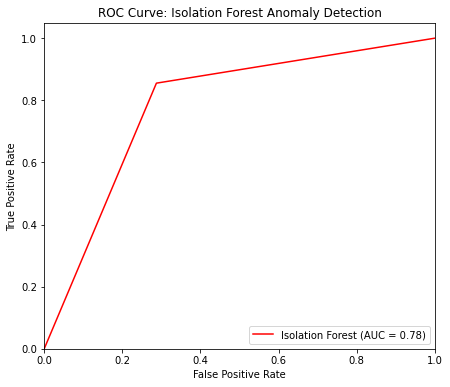

In [ ]:
X_test_unsupervised = X_test_unsupervised.reindex(columns=X_train_unsupervised.columns, fill_value=0)
y_pred_iso = iso_forest.predict(X_test_unsupervised)

y_pred_anomalies = (y_pred_iso == -1).astype(int) 

if 'evil' in unsupervised_test_df.columns:
    print("\nClassification Report:")
    print(classification_report(y_test_unsupervised, y_pred_anomalies))

    auc_score = roc_auc_score(y_test_unsupervised, y_pred_anomalies)
    print(f"\nIsolation Forest Test AUROC: {auc_score:.3f}")
    fpr, tpr, _ = roc_curve(y_test_unsupervised, y_pred_anomalies)

    plt.figure(figsize=(7, 6))
    plt.plot(fpr, tpr, label=f'Isolation Forest (AUC = {auc_score:.2f})', color='red')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve: Isolation Forest Anomaly Detection')
    plt.legend(loc='lower right')

    plt.show()

The isolation forest model performed very well with a reported 0.83 AUC. And the model only took about 5 seconds to train. 

### XGBoost

C:\Users\Naihe\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [15:57:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


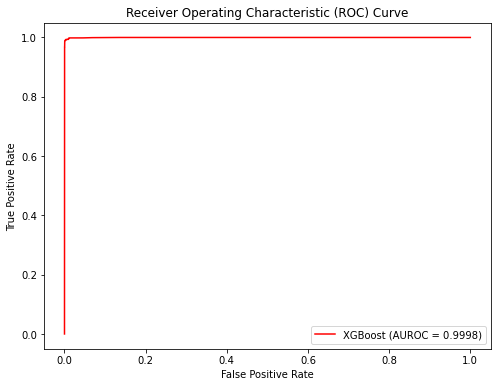

AUROC Score: 0.9998


In [ ]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

xgb_model = xgb.XGBClassifier(
    n_estimators=200, 
    learning_rate=0.05,
    max_depth=6,
    scale_pos_weight=6, 
    use_label_encoder=False,  
    eval_metric='logloss'         
)

xgb_model.fit(X_train_imb, y_train_imb)

y_probs = xgb_model.predict_proba(X_test_imb)[:, 1]  

auroc_score = roc_auc_score(y_test_imb, y_probs)

fpr, tpr, _ = roc_curve(y_test_imb, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'XGBoost (AUROC = {auroc_score:.4f})', color = 'red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

print(f"AUROC Score: {auroc_score:.4f}")


Selected XGBoost since it is good at handling imbalanced data. We can tune the \[scale_pos_weight\] parameter to the ratio of negative/postive of the label. But again, the result shows a typical overfitting. there must be soomething wrong with the data partition that I cannot identify. Also the downside of XGBoost which is the same with the Logistic Regression is that it only learns the patterns seen in the training, will not be able to handle new patterns potentially in the real environment. 

### Autoencoder

The autoencoder is selected since it is trained to minimize reconstruction error (difference between input and reconstructed output). In the case of anomally detection which the data is extremely imbalanced, the malicious observation will become very hard to reconstruct. Therefore autoencoder should be a great candidate. 

In [18]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

unsupervised_train_df = pd.read_csv('labelled_training_data.csv')
unsupervised_test_df = pd.read_csv('labelled_testing_data.csv')
unsupervised_validation_df = pd.read_csv('labelled_validation_data.csv')

X_train, y_train = feature_engineering(unsupervised_train_df)
X_test, y_test = feature_engineering(unsupervised_test_df)
X_val, y_val = feature_engineering(unsupervised_validation_df)

train_columns = X_train.columns
X_test = X_test.reindex(columns=train_columns, fill_value=0)
X_val = X_val.reindex(columns=train_columns, fill_value=0)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

input_dim = X_train_scaled.shape[1]

input_layer = Input(shape=(input_dim,))
encoder = Dense(64, activation='relu')(input_layer)
bottleneck = Dense(32, activation='relu')(encoder)
decoder = Dense(64, activation='relu')(bottleneck)
output_layer = Dense(input_dim, activation='linear')(decoder)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer=Adam(0.001), loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = autoencoder.fit(
    X_train_scaled, X_train_scaled,
    epochs=100,
    batch_size=256,
    validation_data=(X_val_scaled, X_val_scaled),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
2982/2982 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.3677 - val_loss: 0.4690
Epoch 2/100
2982/2982 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.1094 - val_loss: 0.3054
Epoch 3/100
2982/2982 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.0725 - val_loss: 0.2854
Epoch 4/100
2982/2982 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.0708 - val_loss: 0.2650
Epoch 5/100
2982/2982 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.0653 - val_loss: 0.2307
Epoch 6/100
2982/2982 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.0737 - val_loss: 0.1772
Epoch 7/100
2982/2982 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.0418 - val_loss: 0.0913
Epoch 8/100
2982/2982 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.0233 - val_loss: 0.2045
Epoch 9/100
2982/2982 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.0365 - val_loss: 0.1304
Epoch 10/100
2982/2982 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.0273 - val_loss: 0.1011
Epoch 11/100
2982/2982 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.0254 - val_loss: 0.1024
Epoch 12/100
2982/2

5906/5906 ━━━━━━━━━━━━━━━━━━━━ 3s 565us/step
Test AUROC: 0.9693


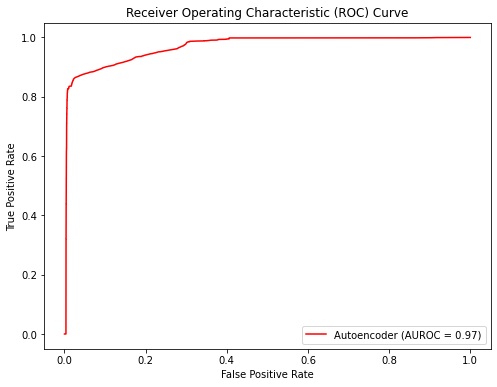

In [20]:
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

def get_reconstruction_error(model, data):
    reconstructions = model.predict(data)
    return np.mean(np.power(data - reconstructions, 2), axis=1)

test_error = get_reconstruction_error(autoencoder, X_test_scaled)

auroc = roc_auc_score(y_test, test_error)
print(f"Test AUROC: {auroc:.4f}")

fpr, tpr, _ = roc_curve(y_test, test_error)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Autoencoder (AUROC = {auroc:.2f})', color = 'red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

The autoencoder model also works too good, which implies overfitting of the model. 

### Conclusion

The isolation forest and XGBoost trained very fast. The autoencoder and logistic regression were not too slow either. All four models are at leaset globally explainable. But the performance of three of the four models implied overfitting which is very concerning. If the problem still cannot be identified, I will have to choose isolation forest for the future deployment. 